In [1]:
import numpy as np
import matplotlib.pyplot as plt
from polynomials import *
from scipy.optimize import curve_fit
import time as time
from tqdm import tqdm

def produce_overlaps(torus, voids, ellipsoids):
    from numpy import isfinite, logical_or, stack, zeros

    all_bodies = [torus, voids] + ellipsoids

    for i, body in enumerate(all_bodies):
        for j in range(body.shape[2]):
            layer = body[:,:,j]

            if i == 0 and j == 0:
                mask = isfinite(layer)
                Nx, Ny = layer.shape
            else:
                mask = logical_or(mask, isfinite(layer))

    masked_bodies = []
    for body in all_bodies:
        layers = []
        for j in range(body.shape[2]):
            layer = body[:,:,j]
            layers.append(layer[mask])
        masked_bodies.append(stack(layers, axis=1))
        
    masked_overlaps = []
    for idx, masked_body in enumerate(masked_bodies):
        if idx == 0:
            trimmed_body = masked_body
            old_edges = masked_body
        else:
            trimmed_body, new_edges = subtract_all_edges(masked_body, old_edges)
            old_edges = new_edges

        masked_overlaps.append(get_overlap(trimmed_body))

    overlaps = []
    for mo in masked_overlaps:
        overlap = zeros(shape=(Nx, Ny))
        overlap[mask] = mo
        overlaps.append(overlap)
    
    return overlaps

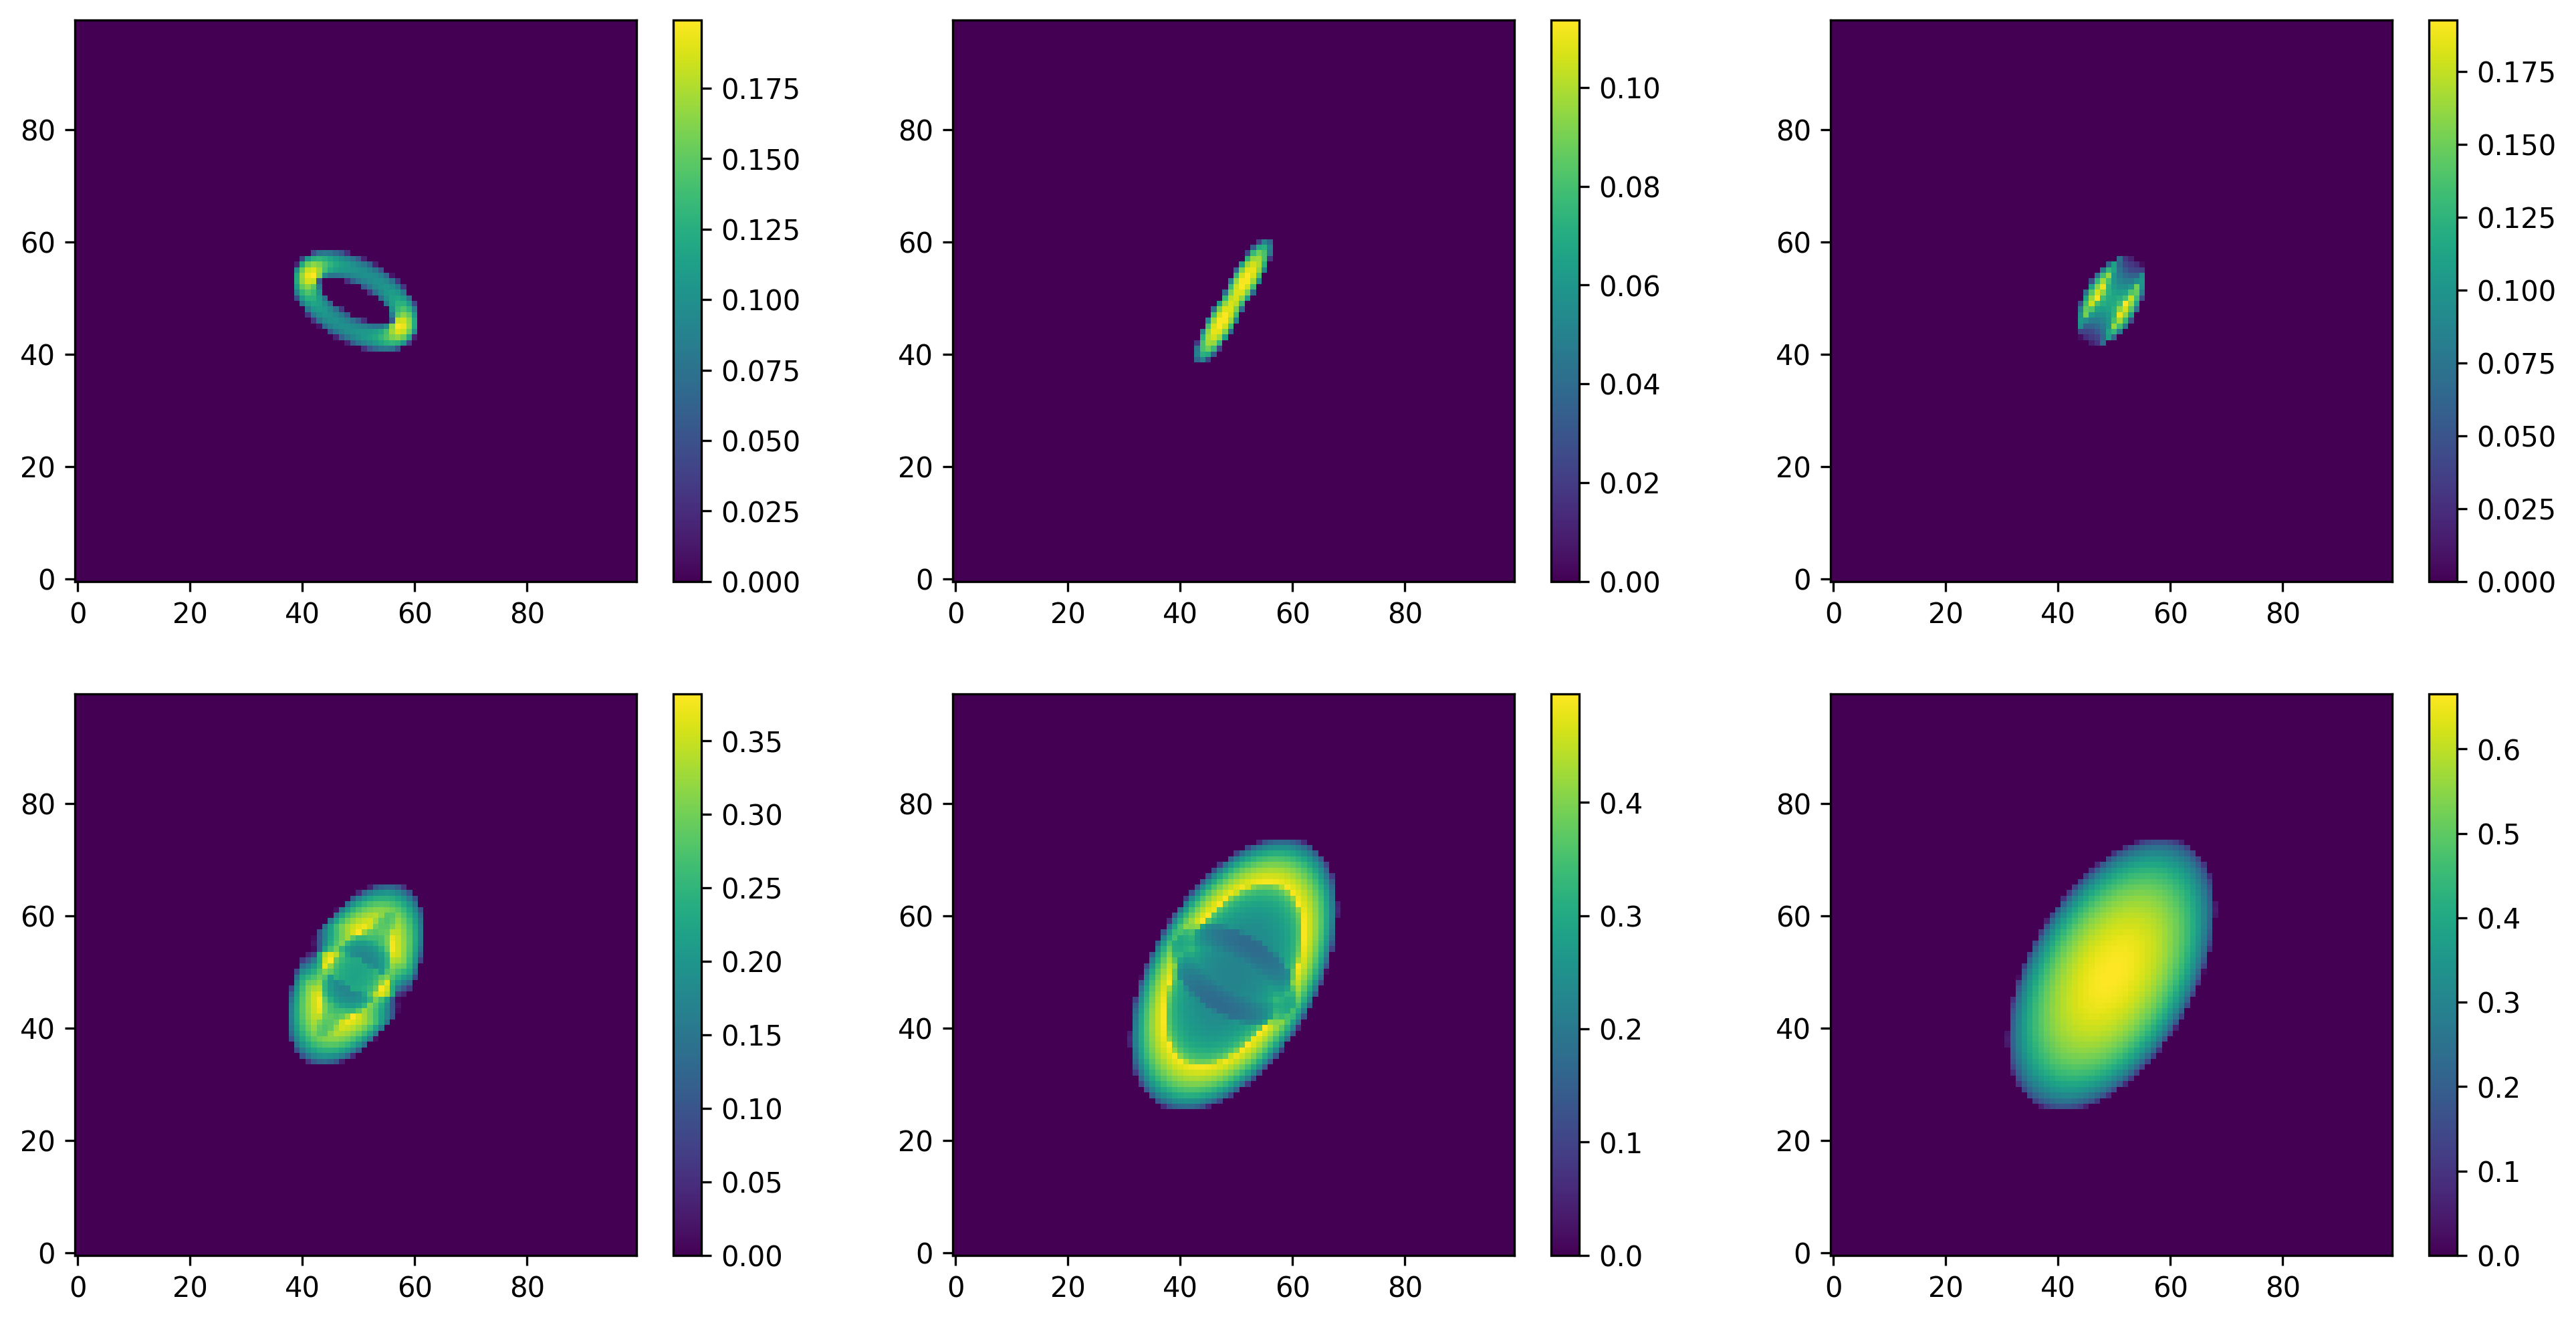

In [2]:
N = 100
x = np.linspace(-1, 1, N, endpoint=True)
z = np.linspace(-1, 1, N, endpoint=True)
xx, zz = np.meshgrid(x, z, indexing='ij')

alpha, beta = 30, 30

torus = torus_intercepts(xx, zz, 0.05, 0.05, 0.2, alpha=alpha, beta=beta)
voids = void_intercepts(xx, zz, 0.2, 0.05, 0.1, alpha=alpha, beta=beta)
ellipsoid1 = ellipsoid_intercepts(xx, zz, 0.2, 0.1, alpha=alpha, beta=beta)
ellipsoid2 = ellipsoid_intercepts(xx, zz, 0.4, 0.2, alpha=alpha, beta=beta)
ellipsoid3 = ellipsoid_intercepts(xx, zz, 0.6, 0.3, alpha=alpha, beta=beta)

result = produce_overlaps(torus, voids, [ellipsoid1, ellipsoid2, ellipsoid3])

fig, axes = plt.subplots(2, 3, figsize=(16,8), dpi=300)
total_img = 0
for ax, img in zip(axes.flatten(), result):
    total_img += img

    im = ax.imshow(img, origin='lower')
    plt.colorbar(im, ax=ax)

im = axes.flatten()[-1].imshow(total_img, origin='lower')
plt.colorbar(im, ax=axes.flatten()[-1])

plt.show()

### Benchmarks

In [13]:
Ns = [10, 30, 60, 100, 150, 200, 300, 500, 700, 1000]
means = []
stds = []

for N in Ns:
    x = 0.6*np.linspace(-1, 1, N, endpoint=True)
    z = 0.6*np.linspace(-1, 1, N, endpoint=True)
    xx, zz = np.meshgrid(x, z, indexing='ij')

    def func(xx, zz):

        alpha, beta = 30, 0
        
        torus = torus_intercepts(xx, zz, 0.05, 0.05, 0.2, alpha=alpha, beta=beta)
        voids = void_intercepts(xx, zz, 0.2, 0.05, 0.1, alpha=alpha, beta=beta)
        ellipsoid1 = ellipsoid_intercepts(xx, zz, 0.2, 0.1, alpha=alpha, beta=beta)
        ellipsoid2 = ellipsoid_intercepts(xx, zz, 0.4, 0.2, alpha=alpha, beta=beta)
        ellipsoid3 = ellipsoid_intercepts(xx, zz, 0.6, 0.3, alpha=alpha, beta=beta)

        _ = produce_overlaps(torus, voids, [ellipsoid1, ellipsoid2, ellipsoid3])

        return
    
    print(f"\n{N}:")
    time = %timeit -o -r10 -n3 func(xx, zz)
    
    means.append(time.average)
    stds.append(time.stdev)


10:
4.94 ms ± 1.69 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)

30:
5.51 ms ± 454 µs per loop (mean ± std. dev. of 10 runs, 3 loops each)

60:
The slowest run took 4.56 times longer than the fastest. This could mean that an intermediate result is being cached.
24.1 ms ± 11.5 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)

100:
21.3 ms ± 4.7 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)

150:
42.8 ms ± 3.75 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)

200:
73.2 ms ± 4.36 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)

300:
183 ms ± 12.9 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)

500:
575 ms ± 4.7 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)

700:
1.26 s ± 95.8 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)

1000:
2.8 s ± 301 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


In [14]:
means = np.array(means)
stds = np.array(stds)

x, y, dy = np.log10(Ns), np.log10(means), stds/(means*np.log(10))

def linear(x, a, b):
    return a * x + b

popt, pcov = curve_fit(linear, x[3:], y[3:], sigma=dy[3:], p0=[2, -3])

a, da = popt[0], pcov[0,0]**0.5
b, db = popt[1], pcov[1,1]**0.5

print(a, da)

x_array = np.linspace(1, 3, 1000, endpoint=True)
fit = linear(x_array, a, b)

2.2064914530496162 0.03140382327434387


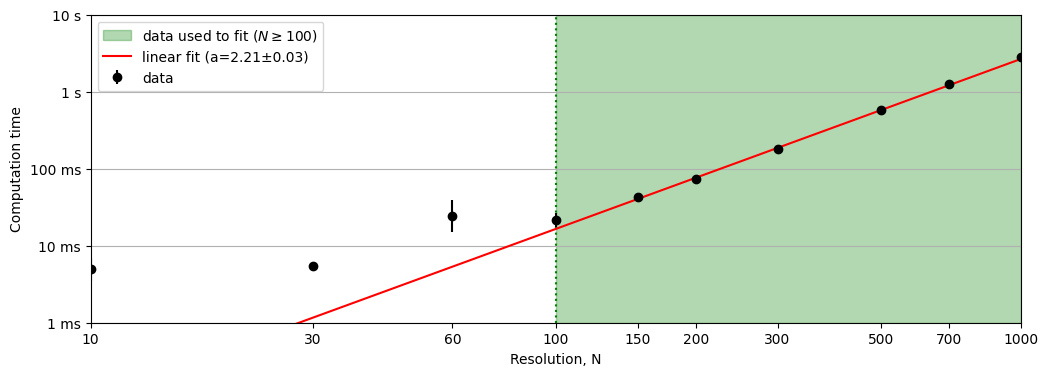

In [15]:
means = np.array(means)
stds = np.array(stds)

plt.figure(figsize=(12,4))

plt.errorbar(x, y, yerr=dy, fmt='o', color='k', ecolor='k', label='data')
plt.fill_between([2, 3], [-3, -3], [1, 1], color='g', alpha=0.3, label='data used to fit ($N\geq100$)')
plt.plot([2, 2], [-3, 1], c='g', linestyle='dotted')

plt.plot(x_array, fit, c='r', label=f'linear fit (a={np.round(a, 2)}±{np.round(da, 2)})')

plt.xlabel('Resolution, N'); plt.ylabel('Computation time')
plt.xlim(1, 3); plt.ylim(-3, 1)
plt.xticks(np.log10(Ns), Ns); plt.yticks([-3, -2, -1, 0, 1], ['1 ms', '10 ms', '100 ms', '1 s', '10 s'])
plt.legend()
plt.grid(axis='y')
plt.show()

### subtract_edge algorithm

In [6]:
def add_edge(ax, y, x1, x2, dy=0.1, c='gray'):
    ax.plot([x1, x2], [y, y], c=c)
    ax.plot([x1, x1], [y-dy/2, y+dy/2], c=c)
    ax.plot([x2, x2], [y-dy/2, y+dy/2], c=c)

    ax.annotate('e1', (x1, y+0.1), c=c)
    ax.annotate('e2', (x2, y+0.1), c=c)

def add_body(ax, y, x1, x2, loc='left', c='firebrick'):
    ax.plot([x1, x2], [y, y], 'o-', c=c)

    if loc == 'left':
        l1, l2 = 'y1', 'y2'
    else:
        l1, l2 = 'y3', 'y4'
    ax.annotate(l1, (x1, y+0.1), c=c)
    ax.annotate(l2, (x2, y+0.1), c=c)

def add_new_edge(ax, y, x1, x2, dy=0.1, loc='middle', c='steelblue'):
    ax.plot([x1, x2], [y, y], c=c)
    ax.plot([x1, x1], [y-dy/2, y+dy/2], c=c)
    ax.plot([x2, x2], [y-dy/2, y+dy/2], c=c)

    if loc == 'left':
        offset = -0.2
        l1, l2 = 'e1', 'e2'
    elif loc == 'middle':
        offset = 0.1
        l1, l2 = 'e3', 'e4'
    else:
        offset = -0.2
        l1, l2 = 'e5', 'e6'
    ax.annotate(l1, (x1, y+offset), c=c)
    ax.annotate(l2, (x2, y+offset), c=c)

def add_new_body(ax, y, x1, x2, loc='left', c='limegreen'):
    ax.plot([x1, x2], [y, y], 'o-', c=c)

    if loc == 'left':
        l1, l2 = 'y1', 'y2'
    else:
        l1, l2 = 'y3', 'y4'
    ax.annotate(l1, (x1, y+0.1), c=c)
    ax.annotate(l2, (x2, y+0.1), c=c)

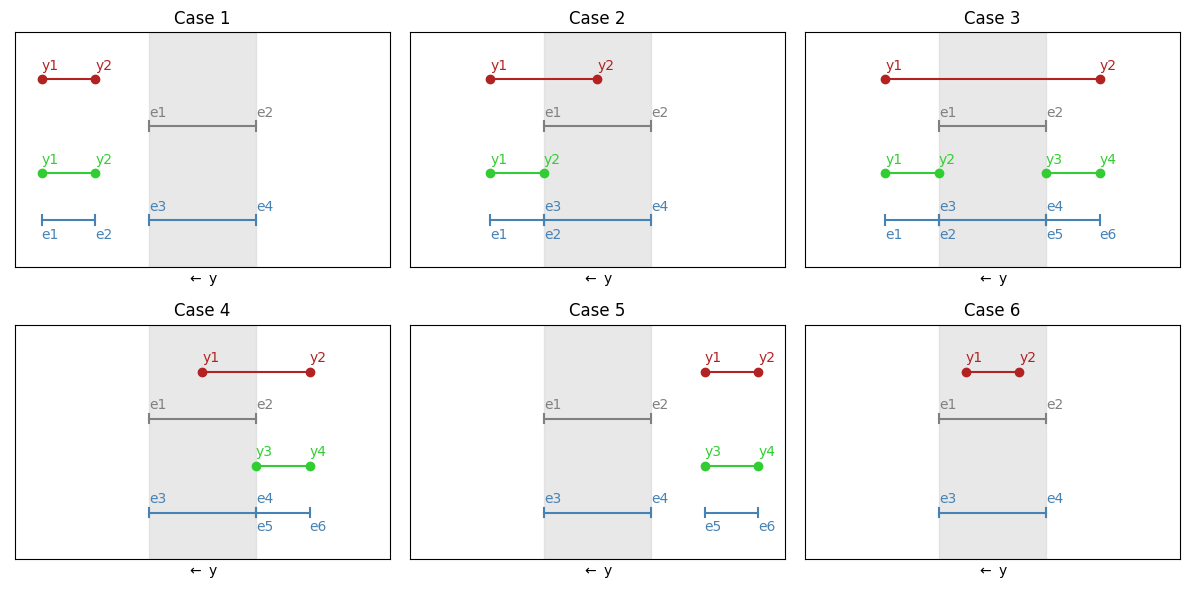

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(12,6))
for i, ax in enumerate(axes.flatten(), start=1):
    ax.set_title(f"Case {i}")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-0.5, 2)
    ax.set_xlabel('$\leftarrow$ y')
    ax.fill_between([-1, 1], [-0.5, -0.5], [2, 2], color='lightgray', alpha=0.5)

    add_edge(ax, 1, -1, 1)
    add_new_edge(ax, 0, -1, 1)

ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

# Case 1
add_body(ax1, 1.5, -3, -2)
add_new_body(ax1, 0.5, -3, -2, loc='left')
add_new_edge(ax1, 0, -3, -2, loc='left')

# Case 2
add_body(ax2, 1.5, -2, 0)
add_new_body(ax2, 0.5, -2, -1, loc='left')
add_new_edge(ax2, 0, -2, -1, loc='left')

# Case 3
add_body(ax3, 1.5, -2, 2)
add_new_body(ax3, 0.5, -2, -1, loc='left'); add_new_body(ax3, 0.5, 1, 2, loc='right')
add_new_edge(ax3, 0, -2, -1, loc='left'); add_new_edge(ax3, 0, 1, 2, loc='right')

# Case 4
add_body(ax4, 1.5, 0, 2)
add_new_body(ax4, 0.5, 1, 2, loc='right')
add_new_edge(ax4, 0, 1, 2, loc='right')

# Case 5
add_body(ax5, 1.5, 2, 3)
add_new_body(ax5, 0.5, 2, 3, loc='right')
add_new_edge(ax5, 0, 2, 3, loc='right')

# Case 6
add_body(ax6, 1.5, -0.5, 0.5)

plt.tight_layout()
plt.savefig('/users/liam/Desktop/cases.png', dpi=300, bbox_inches='tight')
plt.show()

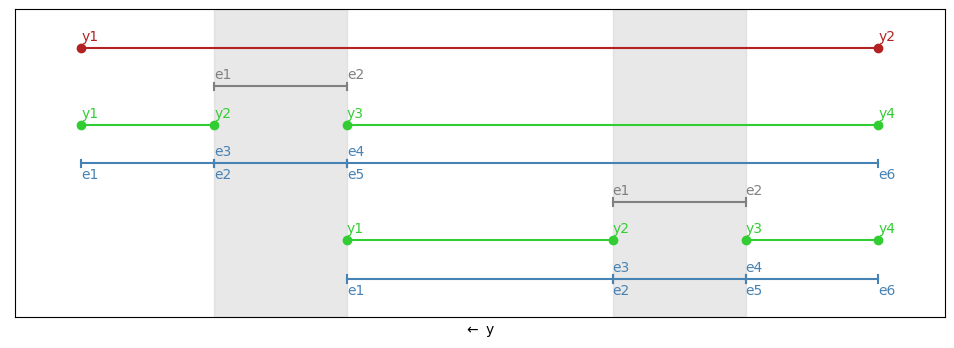

In [8]:
fig, ax = plt.subplots(figsize=(12,4))

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-2, 2)
ax.set_xlabel('$\leftarrow$ y')

add_body(ax, 1.5, -3, 3)

add_edge(ax, 1, -2, -1)
ax.fill_between([-2, -1], [-2, -2], [2, 2], color='lightgray', alpha=0.5)
add_edge(ax, -0.5, 1, 2)
ax.fill_between([1, 2], [-2, -2], [2, 2], color='lightgray', alpha=0.5)

add_new_body(ax, 0.5, -3, -2, loc='left')
add_new_body(ax, 0.5, -1, 3, loc='right')

add_new_edge(ax, 0, -3, -2, loc='left'); add_new_edge(ax, 0, -2, -1, loc='middle'); add_new_edge(ax, 0, -1, 3, loc='right')

add_new_body(ax, -1, -1, 1, loc='left'); add_new_body(ax, -1, 2, 3, loc='right')

add_new_edge(ax, -1.5, -1, 1, loc='left'); add_new_edge(ax, -1.5, 1, 2, loc='middle'); add_new_edge(ax, -1.5, 2, 3, loc='right')

plt.savefig('/users/liam/Desktop/combined_case.png', dpi=300, bbox_inches='tight')
plt.show()

### Comparison with old method

In [9]:
def old_method(frame, angle=30, tR=0.2, ta=0.05, tb=0.05, va=0.2, vb=0.1, offset=0.2, e1a=0.1, e1b=0.1, e2a=0.4, e2b=0.2, e3a=0.6, e3b=0.3):
    from numpy import array, sin, cos, deg2rad

    alpha, beta = deg2rad(angle), deg2rad(angle)
    xx, yy, zz = frame
    x = xx[:,0,0]
    dx = x[1] - x[0]

    matrix = array([[cos(alpha)*cos(beta), sin(alpha)*cos(beta), -sin(beta)], [-sin(alpha), cos(alpha), 0], [cos(alpha)*sin(beta), sin(alpha)*sin(beta), cos(beta)]])
    
    xx_rot = matrix[0,0] * xx + matrix[0,1] * yy + matrix[0,2] * zz
    yy_rot = matrix[1,0] * xx + matrix[1,1] * yy + matrix[1,2] * zz
    zz_rot = matrix[2,0] * xx + matrix[2,1] * yy + matrix[2,2] * zz

    torus = ((tR - (yy_rot**2 + zz_rot**2)**0.5)**2 / tb**2 + xx_rot**2 / ta**2 <= 1)

    voidsL = ((xx_rot + offset)**2 / va**2 + (yy_rot**2 + zz_rot**2) / vb**2  <= 1)
    voidsR = ((xx_rot - offset)**2 / va**2 + (yy_rot**2 + zz_rot**2) / vb**2  <= 1)
    voids = np.logical_or(voidsL, voidsR)

    ellipsoid1 = (xx_rot**2 / e1a**2 + (yy_rot**2 + zz_rot**2) / e1b**2  <= 1)
    ellipsoid2 = (xx_rot**2 / e2a**2 + (yy_rot**2 + zz_rot**2) / e2b**2  <= 1)
    ellipsoid3 = (xx_rot**2 / e3a**2 + (yy_rot**2 + zz_rot**2) / e3b**2  <= 1)

    overlaps = []
    for idx, shape in enumerate([torus, voids, ellipsoid1, ellipsoid2, ellipsoid3]):

        if idx == 0:
            overlaps.append(np.sum(shape, axis=2) * dx)
            not_taken = 1 - shape
        else:
            overlaps.append(np.sum(shape * not_taken, axis=2) * dx)
            not_taken = not_taken * (1 - shape)

    return overlaps

def new_method(frame, angle=30, tR=0.2, ta=0.05, tb=0.05, va=0.2, vb=0.1, offset=0.2, e1a=0.1, e1b=0.1, e2a=0.4, e2b=0.2, e3a=0.6, e3b=0.3):

    alpha, beta = angle, angle
    xx, zz = frame

    alpha, beta = 30, 30

    torus = torus_intercepts(xx, zz, ta, tb, tR, alpha=alpha, beta=beta)
    voids = void_intercepts(xx, zz, va, vb, offset, alpha=alpha, beta=beta)
    ellipsoid1 = ellipsoid_intercepts(xx, zz, e1a, e1b, alpha=alpha, beta=beta)
    ellipsoid2 = ellipsoid_intercepts(xx, zz, e2a, e2b, alpha=alpha, beta=beta)
    ellipsoid3 = ellipsoid_intercepts(xx, zz, e3a, e3b, alpha=alpha, beta=beta)

    return produce_overlaps(torus, voids, [ellipsoid1, ellipsoid2, ellipsoid3])

In [10]:
Ns = [10, 50, 100, 150, 200, 250, 300]
samples = 5

times_old = []
times_new = []

differences = []

for N in tqdm(Ns):
    x = np.linspace(-1, 1, N, endpoint=True)
    frame2D = np.meshgrid(x, x, indexing='ij')
    frame3D = np.meshgrid(x, x, x, indexing='ij')

    angles = np.random.uniform(low=0, high=90, size=samples)

    results_old = []
    results_new = []

    t0 = time.time()
    for angle in angles:
        results_old.append(old_method(frame3D, angle=angle))
    times_old.append((time.time() - t0) / samples)
    

    t0 = time.time()
    for angle in angles:
        results_new.append(new_method(frame2D, angle=angle))
    times_new.append((time.time() - t0) / samples)

    difference = 0
    for result_old, result_new in zip(results_old, results_new):
        for old, new in zip(result_old, result_new):
            difference += np.mean(old - new)

    differences.append(difference / (5 * samples))

times_old = np.array(times_old)
times_new = np.array(times_new)
differences = np.array(differences)


  0%|          | 0/7 [00:00<?, ?it/s]


AttributeError: 'TimeitResult' object has no attribute 'time'

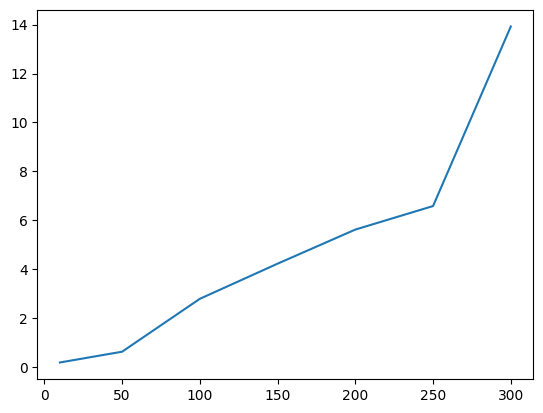

In [ ]:
plt.plot(Ns, times_old / times_new)

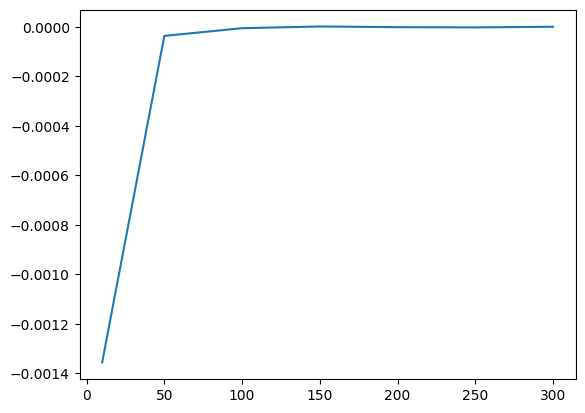

In [ ]:
plt.plot(Ns, differences)

In [1]:
import numpy as np

In [14]:
matrix = np.random.normal(size=(10, 100, 100))
array = np.random.normal(size=10)

np.matmul(array.T, matrix)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 10)